# **Text Mining**

In [ ]:
# pip install gensim 
# pip install hdbscan
# pip install wordfreq

## Import statements

In [18]:
import ast
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bs4 import BeautifulSoup
from collections import Counter
import csv
from dateutil import parser
from hdbscan import HDBSCAN
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import os
import pandas as pd
import random
import re
import requests
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import string
import time
from urllib.parse import urljoin
from urllib.parse import urlparse
from wordcloud import WordCloud
from wordfreq import zipf_frequency

In [ ]:
nltk.download('punkt_tab')  #: to comment if already downloaded
nltk.download('stopwords')  #: to comment if already downloaded
nltk.download('wordnet')  #: to comment if already downloaded
nltk.download('omw-1.4')  #: to comment if already downloaded   

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Constant definitions

In [19]:
# --- CONFIGURATION OF COLORS ---

GREEN = "\033[92m"
RED = "\033[91m"
BLUE = "\033[94m"
RESET = "\033[0m"

In [4]:
#--- CONFIGURATION OF STOPWORDS ---

stop_words = set(stopwords.words('english'))
stop_words.add("s") # Load English stopwords with an "s" at their ending
#stem = nltk.stem.SnowballStemmer("english")

custom_stopwords = {
    # High-frequency but uniteresting
    "one", "two", "first", "second", "new", "more", "most", "many", "much",
    "even", "still", "just", "really", "very", "well", "good", "great", "better",
    "every", "each", "some", "any", "another", "few", "several", "also", "like", "anti", "something",

    # Adverbes
    "often", "sometimes", "usually", "typically", "generally", "likely", "probably",
    "maybe", "perhaps", "always", "never", "already", "again", "soon", "now", "then",
    "various", "numerous", "multiple", "today", "yesterday", "tomorrow",
    "currently", "recently", "eventually", "rarely", "occasionally",

    # Generic verbs (not in standard stopwords)
    "get", "got", "make", "made", "take", "took", "use", "used", "using", "help", "helps",
    "see", "seen", "know", "known", "show", "shows", "say", "says", "said", "find", "found",

    # Generic nouns with low semantic value 
    "thing", "things", "stuff", "kind", "kinds", "type", "types", "way", "ways",
    "part", "parts", "area", "areas", "aspect", "aspects", "place", "places",
    "lot", "bit", "time", "day", "week", "month", "year",
    "someone", "anyone", "everyone", "nobody",

    # Linking words
    "however", "therefore", "thus", "though", "although", "because", "while", "since",
    "before", "after", "during", "when", "where", "whose", "which", "who", "whom",


# Attention tester sans (tjs utile ou pas ?)

    # For MBG
    "mindbodygreen", "mbg", "mind", "body", "green", "mindbody", "bodygreen", "mbg.com", "editor", "editors", "read", "reading",

    # Names
    "sarah", "regan", "amanda", "shayne", "kelly", "gansalves", "abby", "moore", "jason", "wachob", "julie", 
    "nguyen", "braelyn", "wood", "alisa", "cowell", "alexandra", "engler", "ava", "durgin", "carleigh", "ferrante", 
    "hannah", "margaret", "allen", "molly", "knudsen", "emma", "engler", "devon", "barrow", "eliza", "sullivan", 
    "loewe", "jamie", "scheinder", "frye", "lindsay", "boyers", "kelsea", "samson", "editorial", "jamie", "scheinder", "ryan", 
    "brady", "megan", "falk", "julia", "guerra", "stephanie", "eckelkamp", "india", "edwards"
}

ALL_STOPWORDS = stop_words.union(custom_stopwords)

In [5]:
# --- CONFIGURATION OF DATE EXTRACTION ---

date_patterns = [
        # Detect dates like : "September 17, 2024" and "Sep 17, 2024"
        r'\b(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|'
        r'Jul(?:y)?|Aug(?:ust)?|Sep(?:t(?:ember)?)?|Oct(?:ober)?|Nov(?:ember)?|'
        r'Dec(?:ember)?)\s\d{1,2},\s\d{4}\b',

        # Detect dates like : "September 17 2024" 
        r'\b(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|'
        r'Jul(?:y)?|Aug(?:ust)?|Sep(?:t(?:ember)?)?|Oct(?:ober)?|Nov(?:ember)?|'
        r'Dec(?:ember)?)\s\d{1,2}\s\d{4}\b',

        # Detect dates like : "17 September 2024"
        r'\b\d{1,2}\s(?:Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|'
        r'Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:t(?:ember)?)?|Oct(?:ober)?|'
        r'Nov(?:ember)?|Dec(?:ember)?)\s\d{4}\b',

        # Detect dates like : "2024-09-17" (ISO)
        r'\b\d{4}-\d{2}-\d{2}\b',

        # Detect dates like : "09/17/2024" and "9/17/24" 
        r'\b\d{1,2}/\d{1,2}/\d{2,4}\b'
    ]

## Preprocessing, Normalization, and Tokenization

In [6]:
def get_filenames(source_name): 
    # Create all files from a source using the name specified in the source cell [21]
    
    directory_name = "data"
    
    if not os.path.exists(directory_name): # Checks if the 'data' folder exists
        os.makedirs(directory_name) # Setup the output directory
        print(f"{GREEN}Created directory : {directory_name}{RESET}")
    
    # We assume that source_name contains no spaces. If changed, add : source_name = source_name.replace(" ", "_")

    return {"raw":          os.path.join(directory_name, f"{source_name}_raw_html.csv"),
            'content_date': os.path.join(directory_name, f"{source_name}_content_date.csv"),
            "corpus":       os.path.join(directory_name, f"{source_name}_corpus.csv"),
            "cleaned":      os.path.join(directory_name, f"{source_name}_cleaned.csv"),
            "norm":         os.path.join(directory_name, f"{source_name}_corpus_norm.csv"),
            "tokenized":    os.path.join(directory_name, f"{source_name}_corpus_tokenized.csv"),
            "nodes" :       os.path.join(directory_name, f"{source_name}_nodes.csv"),
            "edges" :       os.path.join(directory_name, f"{source_name}_edges.csv")}

#### Date extraction

In [7]:
def extract_date_from_html(html):

    soup = BeautifulSoup(html, "html.parser")
    text = soup.get_text(separator=" ", strip=True)

    for pattern in date_patterns:
        matches = re.findall(pattern, text, re.IGNORECASE) # Find all date strings in the text that match one of the date pattern

        for match in matches:  
            try: # Try to convert the matched string into a date object to have all the dates with the same format
                date = parser.parse(match, fuzzy = False) # Parse convert the match object into a datetime with a strict parsing (fuzzy = False -> takes only set apart dates, not dates in the text) 

                if 1990 <= date.year <= 2030: # Keep only dates in a reasonable year range
                    return date

            except:
                continue # If parsing fails, ignore this match and move to the next match

    return None


In [65]:
def content_date_csv_file(input_csv, output_csv, domain):

    df = pd.read_csv(input_csv) # Take the csv file with the raw html as the input

    if 'html' not in df.columns: # Verify that the html column exists
        raise ValueError(f"The html column is missing in: {input_csv}")
    
    df = df[df['url'].str.startswith(tuple(domain))] # We want the content of the internal links (at least for mind body green)
    
    df['date'] = df['html'].apply(extract_date_from_html) # Extract date from the html column

    df = df[['url', 'date', 'html']] # Keep columns in the desired order with the 3 columns

    df.to_csv(output_csv, index=False, encoding='utf-8') # Create a new csv file

    return df

#### Corpus extraction

In [9]:
def get_corpus(html):
    # Converts an HTML text string for Python
    
    soup = BeautifulSoup(html, "html.parser") # Stores the result 
    paragraphs = [p.get_text(separator=" ", strip=True) for p in soup.find_all("p") if len(p.get_text(strip=True)) > 10]
    text = " ".join(paragraphs)

    return text

In [10]:
def corpus_csv_file(input_csv, output_csv):

    df = pd.read_csv(input_csv) # Take the csv file with the raw html as the input

    if 'html' not in df.columns: # Verify that the html colon exists
        raise ValueError(f"The html column is missing in: {input_csv}")

    df['corpus_text'] = df['html'].apply(get_corpus) # Cleans the html column

    if 'date' in df.columns :
        df = df[['url', 'date', 'corpus_text']] # Keep the url and text colon (not the raw html)
    else :
        df = df[['url', 'corpus_text']]

    df.to_csv(output_csv, index=False, encoding='utf-8') # Creats a new csv file as the output of the function

    return df

#### Cleaning process

In [11]:
def clean_html(html):

    soup = BeautifulSoup(html, 'html.parser')

    for tag in soup(['script', 'style', 'noscript']): # Supress any unessecary tags
        tag.decompose()

    text = soup.get_text(separator=' ', strip=True) # Collect all visible text
    text = re.sub(r'\s+', ' ', text) # Supress any unecessary spaces

    return text

In [12]:
def clean_csv_file(input_csv, output_csv):

    df = pd.read_csv(input_csv) # Take the csv file with the raw html as the input

    if 'corpus_text' not in df.columns: # Verify that the html colon exists
        raise ValueError(f"The corpus column is missing in: {input_csv}")

    df['cleaned_text'] = df['corpus_text'].apply(clean_html) # Cleans the html column

    if 'date' in df.columns :
        df = df[['url', 'date', 'cleaned_text']] # Keep the url and text colon (not the raw html)
    else :
        df = df[['url', 'cleaned_text']]

    df.to_csv(output_csv, index=False, encoding='utf-8') # Creats a new csv file as the output of the function

    return df

#### Normalization process

In [13]:
def normalize_html(text):

    text = text.lower() # Convert all characters to lowercase
    text = re.sub(r'\[\d+\]', ' ', text) # Remove reference markers like [1], [23], etc.
    text = re.sub(r'[^a-z\s]', ' ', text) # Keep only English letters and spaces (remove ponctuation, numbers, and everything that is not a letter)
    text = re.sub(r'\s+', ' ', text) # Replace multiple spaces with a single space

    return text.strip() 

In [14]:
def normalize_csv_file(input_csv, output_csv):

    df = pd.read_csv(input_csv) # Take the csv file with the cleaned text as the input

    if 'cleaned_text' not in df.columns: # Verify that the cleaned text colon exists
        raise ValueError(f"The cleaned text is missing in: {input_csv}")

    df['normalized_text'] = df['cleaned_text'].apply(normalize_html) # Normalize the cleaned text

    if 'date' in df.columns :
        df = df[['url', 'date', 'normalized_text']] # Keep the url and normalized text 
    else : 
        df = df[['url', 'normalized_text']]

    df.to_csv(output_csv, index=False, encoding='utf-8') # Creates a new csv file as the output of the function

    return df

#### Tokenization process

In [15]:
def tokenize_html(text):

    lemmatizer = WordNetLemmatizer()

    tokens = nltk.word_tokenize(text) # Transform the text into a list of words

    tokens = [token for token in tokens if token not in ALL_STOPWORDS] # Remove stopwords
    
    #tokens = [stem.stem(token) for token in tokens] # Apply stemming (racinisation)
    tokens = [lemmatizer.lemmatize(token) for token in tokens] # Apply lemmatization
    #tokens = [lemmatizer.lemmatize(token, pos='v') for token in tokens]
    
    tokens = [t for t in tokens if len(t) > 1] # Remove very short or meaningless tokens 
    tokens = [t for t in tokens if len(t) < 20] # Remove very long or meaningless tokens 

    return tokens

In [16]:
def tokenize_csv_file(input_csv, output_csv):

    df = pd.read_csv(input_csv) # Take the csv file with the normalized text as the input

    if 'normalized_text' not in df.columns: # Verify that the normalized text colon exists
        raise ValueError(f"The normalized text is missing in: {input_csv}")

    df['tokenized_text'] = df['normalized_text'].apply(tokenize_html) # Cleans the html colon

    if 'date' in df.columns :
        df = df[['url', 'date', 'tokenized_text']] # Keep the url and text colon (not the raw html)
    else :
        df = df[['url', 'tokenized_text']]

    df.to_csv(output_csv, index=False, encoding='utf-8') # Creates a new csv file as the output of the function

    return df

#### Configuration and execution

"""A CHANGER CAR Y A UN DOMAINE POUR FEEDSPOT ICI JE SUPPOSE"""

In [ ]:
sources = [
    {"name": "MBG",
     "domain": "https://www.mindbodygreen.com/"}, # We write the specific function without calling it ()
    {"name": "wiki",
     "domain": None}, # Wikipedia does not require domain filtering
    {"name": "blogs",
     "domain": None} 
    ]

EXECUTION

In [ ]:
"""========================== SOURCES PIPELINE =========================="""

"""=== SETUP ==="""
all_tokenized_dicts = {} 

for source in sources:
    source_name = source["name"]
    domain = source["domain"]

    files = get_filenames(source_name)

    print(f"=== SOURCE PROCESSING : {source_name} ===")
    
    print("\n=== DATES EXTRACTION ===")
    
    if domain:
        print(f"{BLUE}[{source_name}] Extracting dates and filtering by domain...{RESET}")
        content_date_csv_file(files["raw"], files["content_date"], domain=domain)
        print(f"{GREEN}Content with dates saved to {files['content_date']}{RESET}")

        input_for_corpus = files["content_date"]
    else:
        input_for_corpus = files["raw"]

    print("\n=== CORPUS EXTRACTION ===")

    print(f"{BLUE}[{source_name}] Extracting the corpus...{RESET}")
    corpus_csv_file(input_for_corpus, files["corpus"])
    print(f"{GREEN}Corpus data saved to {files['corpus']}{RESET}")

    print("\n=== CLEANING ===")

    print(f"{BLUE}[{source_name}] Cleaning the data...{RESET}")
    clean_csv_file(files["corpus"], files["cleaned"])
    print(f"{GREEN}Cleaned text saved to {files['cleaned']}{RESET}")

    print("\n=== NORMALIZATION ===")

    print(f"{BLUE}[{source_name}] Normalizing the data...{RESET}")
    normalize_csv_file(files["cleaned"], files["norm"])
    print(f"{GREEN}Normalized text saved to {files['norm']}{RESET}")

    print("\n=== TOKENIZATION ===")

    print(f"{BLUE}[{source_name}] Tokenizing text...{RESET}")
    df_tokenized = tokenize_csv_file(files["norm"], files["tokenized"])
    print(f"{GREEN}Tokenized data saved in {files['tokenized']}. Rows: {len(df_tokenized)}{RESET}\n")

    current_dict = dict(zip(df_tokenized['url'], df_tokenized['tokenized_text'])) # We transform the csv file with the tokenized text into a dictionnary to make it feet the function above seen in class
    all_tokenized_dicts[source_name] = current_dict

#### Execution

###### For MindBodyGreen

In [ ]:
content_date_MBG_csv = content_date_csv_file("data/MBG_raw_html.csv", "data/MBG_content_date.csv", domain=["https://www.mindbodygreen.com/"])
corpus_MBG_csv = corpus_csv_file("data/MBG_content_date.csv", "data/MBG_corpus.csv")
cleaned_MBG_csv = clean_csv_file("data/MBG_corpus.csv", "data/MBG_cleaned_corpus.csv")
normalized_MBG_csv = normalize_csv_file("data/MBG_cleaned_corpus.csv", "data/MBG_normalized_corpus.csv")
tokenized_MBG_csv = tokenize_csv_file("data/MBG_normalized_corpus.csv", "data/MBG_tokenized_corpus.csv")

###### For Wikipedia

In [24]:
corpus_wiki_csv = corpus_csv_file("data/wiki_raw_html.csv", "data/wiki_corpus.csv")
cleaned_wiki_csv = clean_csv_file("data/wiki_corpus.csv", "data/wiki_cleaned_corpus.csv")
normalized_wiki_csv = normalize_csv_file("data/wiki_cleaned_corpus.csv", "data/wiki_normalized_corpus.csv")
tokenized_wiki_csv = tokenize_csv_file("data/wiki_normalized_corpus.csv", "data/wiki_tokenized_corpus.csv")

###### For Feedspot

In [ ]:
content_date_blogs_csv = content_date_csv_file("data/blogs_raw_html.csv", "data/blogs_content_date.csv", domain="https://www.mindbodygreen.com/")
corpus_blogs_csv = corpus_csv_file("data/blogs_content_date.csv", "data/blogs_corpus.csv")
cleaned_blogs_csv = clean_csv_file("data/blogs_corpus.csv", "data/blogs_cleaned_corpus.csv")
normalized_blogs_csv = normalize_csv_file("data/blogs_cleaned_corpus.csv", "data/blogs_normalized_corpus.csv")
tokenized_blogs_csv = tokenize_csv_file("data/blogs_normalized_corpus.csv", "data/blogs_tokenized_corpus.csv")

## Term document matrix

#### Constant definitions

In [120]:
def build_term_document_matrix(documents, min_doc_freq=2, max_doc_freq=None):

    # Step 1: Build a vocabulary (unique terms across all documents)
    vocabulary = set(token for tokens in documents.values() for token in tokens)  # The vocabulary contains all tokens appearing in the corpus. Each token is listed only once, even if it appears multiple times.

    # Step 2: Count term frequencies for each document
    term_frequencies = {doc: Counter(tokens) for doc, tokens in documents.items()}  # The dictionnary has the name of a document as a key and a counter of token frequency as value

    # Step 3: Construct the term-document matrix (a list of dictionnaries that is transform into pandas dataframe where each column corresponds to a token, each row to a document. Each dictionnary has a token as key and a list of the frequency of its number of appears in all documents as value)
    td_matrix = pd.DataFrame(
        {term: [term_frequencies[doc].get(term, 0) for doc in documents] for term in vocabulary},
        index = documents.keys())  

    # Step 4: Filter terms that appear in fewer / more than x documents
    document_frequency = (td_matrix > 0).sum(axis=0) # Document frequency counts in how many documents each token appears

    if min_doc_freq is not None:
        td_matrix = td_matrix.loc[:, document_frequency >= min_doc_freq] # We only keep tokens if they appears a minimum of times. This removes very rare tokens that may not be informative.

    if max_doc_freq is not None:
        document_frequency = (td_matrix > 0).sum(axis=0)
        td_matrix = td_matrix.loc[:, document_frequency <= max_doc_freq] # We only keep tokens if they appears less than a maximum of times. This removes very common tokens that may be uninformative.

    vocabulary = td_matrix.columns.tolist() # Update the vocabulary to include only the tokens kept after filtering.

    return td_matrix, vocabulary

#### Execution

###### For MindBodyGreen

In [121]:
print("\n=== BUILDING TERM-DOCUMENT MATRIX FOR MBG ===")

MBG_tokenized_dict = dict(zip(tokenized_MBG_csv['url'], tokenized_MBG_csv['tokenized_text']))  # We transform the csv file with the tokenized text into a dictionnary to make it feet the function above seen in class
MBG_td_matrix, MBG_vocab = build_term_document_matrix(MBG_tokenized_dict, min_doc_freq=4, max_doc_freq=400)

print(MBG_vocab[:20])
print(MBG_td_matrix)


=== BUILDING TERM-DOCUMENT MATRIX FOR MBG ===
['fluctuation', 'misinformation', 'systematic', 'nih', 'chakras', 'movement', 'exists', 'referring', 'recreational', 'cooky', 'activates', 'fabulous', 'controversial', 'overtime', 'suffer', 'diy', 'incorporated', 'regulate', 'drastic', 'black']
                                                    fluctuation  \
https://www.mindbodygreen.com/partner/ikea                    0   
https://www.mindbodygreen.com/articles/ever-hea...            0   
https://www.mindbodygreen.com/articles/how-to-r...            0   
https://www.mindbodygreen.com/articles/gua-sha-...            0   
https://www.mindbodygreen.com/articles/unexpect...            0   
...                                                         ...   
https://www.mindbodygreen.com/articles/nuts-and...            0   
https://www.mindbodygreen.com/articles/best-ket...            0   
https://www.mindbodygreen.com/articles/the-12-m...            0   
https://www.mindbodygreen.com/articles

###### For Wikipedia

In [28]:
print("\n=== BUILDING TERM-DOCUMENT MATRIX FOR WIKIPEDIA===")

wiki_tokenized_dict = dict(zip(tokenized_wiki_csv['url'], tokenized_wiki_csv['tokenized_text']))
wiki_td_matrix, wiki_vocab = build_term_document_matrix(wiki_tokenized_dict, min_doc_freq=3, max_doc_freq=285)

print(wiki_vocab[:20])
print(wiki_td_matrix)


=== BUILDING TERM-DOCUMENT MATRIX FOR WIKIPEDIA===
['actually', 'far', 'following', 'tool', 'consequence', 'whole', 'gained', 'significant', 'th', 'cause', 'time', 'work', 'especially', 'greater', 'continued', 'available', 'compared', 'little', 'indicates', 'important']
                                                 actually  far  following  \
https://en.wikipedia.org/wiki/LCCN_(identifier)         0    0          0   
https://en.wikipedia.org/wiki/Maternal_health           2    2          4   
https://en.wikipedia.org/wiki/Orienteering              1    1          4   
https://en.wikipedia.org/wiki/Pessimism                 1    0          1   
https://en.wikipedia.org/wiki/Holocene                  0    1          8   
https://en.wikipedia.org/wiki/Etiology                  1    0          1   
https://en.wikipedia.org/wiki/Baluster                  0    1          1   

                                                 tool  consequence  whole  \
https://en.wikipedia.org/wiki/LCCN

## TF-IDF

#### Definitions implemantation

In [122]:
def tf_idf(td_matrix) : # Calculate the TF-IDF matrix from the Term-Document matrix

    row_sums = td_matrix.sum(axis=1) # Compute the total number of tokens in each document (= sum on the td_matrix's rows)
    tf = td_matrix.div(row_sums, axis=0) # Compute Term Frequency (TF). Each term count is divided by the total number of tokens in the corresponding document (normalization). This accounts for differences in document length.
    df = (td_matrix > 0).sum(axis=0) # Compute Document Frequency (DF). For each term (column of the td_matrix), count the number of documents in which the term appears at least once.
    N = td_matrix.shape[0] # Compute the total number of documents. This corresponds to the number of rows in the td_matrix.
    idf = np.log((N) / (df)) # Compute the IDF (Specificity). Terms that appear in many documents receive a lower IDF, while rare terms receive a higher IDF, making them more informative.
    tf_idf = tf.mul(idf, axis=1) # Multiply each item in the tf column by the IDF corresponding so that each term's TF is weighted by its IDF score.

    return(tf_idf)

#### Execution

###### For MindBodyGreen

In [123]:
MBG_tf_idf = tf_idf(MBG_td_matrix)
print(MBG_tf_idf)

                                                    fluctuation  \
https://www.mindbodygreen.com/partner/ikea                  0.0   
https://www.mindbodygreen.com/articles/ever-hea...          0.0   
https://www.mindbodygreen.com/articles/how-to-r...          0.0   
https://www.mindbodygreen.com/articles/gua-sha-...          0.0   
https://www.mindbodygreen.com/articles/unexpect...          0.0   
...                                                         ...   
https://www.mindbodygreen.com/articles/nuts-and...          0.0   
https://www.mindbodygreen.com/articles/best-ket...          0.0   
https://www.mindbodygreen.com/articles/the-12-m...          0.0   
https://www.mindbodygreen.com/articles/health-b...          0.0   
https://www.mindbodygreen.com/articles/higher-p...          0.0   

                                                    misinformation  \
https://www.mindbodygreen.com/partner/ikea                     0.0   
https://www.mindbodygreen.com/articles/ever-hea...     

###### For Wikipedia

In [31]:
wiki_tf_idf = tf_idf(wiki_td_matrix)
print(wiki_tf_idf)

                                                 actually       far  \
https://en.wikipedia.org/wiki/LCCN_(identifier)  0.000000  0.000000   
https://en.wikipedia.org/wiki/Maternal_health    0.001210  0.001210   
https://en.wikipedia.org/wiki/Orienteering       0.001036  0.001036   
https://en.wikipedia.org/wiki/Pessimism          0.001706  0.000000   
https://en.wikipedia.org/wiki/Holocene           0.000000  0.000906   
https://en.wikipedia.org/wiki/Etiology           0.006150  0.000000   
https://en.wikipedia.org/wiki/Baluster           0.000000  0.004909   

                                                 following      tool  \
https://en.wikipedia.org/wiki/LCCN_(identifier)   0.000000  0.015545   
https://en.wikipedia.org/wiki/Maternal_health     0.000667  0.001210   
https://en.wikipedia.org/wiki/Orienteering        0.001142  0.001036   
https://en.wikipedia.org/wiki/Pessimism           0.000470  0.000000   
https://en.wikipedia.org/wiki/Holocene            0.001995  0.000000   

## Similarity Matrix

#### Definitions implementation

In [130]:
def similarity_matrix(tf_idf):
    tf_idf_clean = tf_idf.replace([np.inf, -np.inf], np.nan).fillna(0) # Replace "NaN" with a 0

    # Compute the cosine similarity matrix
    similarity_matrix_tfidf = cosine_similarity(tf_idf_clean) # Each value ranges from 0 (no similarity) to 1 (identical documents).

    # Convert to a DataFrame for better readability (optional)
    similarity_df_tfidf = pd.DataFrame(similarity_matrix_tfidf, index=tf_idf_clean.index, columns=tf_idf_clean.index) # Rows and columns are labeled with document identifiers (index)

    # Display the similarity DataFrame
    display(similarity_df_tfidf)
    return(similarity_df_tfidf)

In [131]:
def plot_similarity_matrix(similarity_df):
    # Plot the similarity matrix
    
    plt.figure(figsize=(14, 11))
    plt.imshow(similarity_df, interpolation='nearest', cmap='viridis')
    plt.colorbar(label='Cosine Similarity')
    plt.title('Document Similarity Matrix')

    # Labels = [url_to_label(url) for url in similarity_df.columns] # We labelized the document not with their full link but their label found with the function (url_to_label)
    
    ax = plt.gca()  # We set the axis to have them set at the right place

    ax.set_xticks([]) 
    ax.set_yticks([])
    
    ax.set_xlabel('Documents')
    ax.set_ylabel('Documents')

    # Optionally, annotate the cells with similarity values
    """for i in range(len(similarity_df)):
        for j in range(len(similarity_df)):
            ax.text(j, i, f"{similarity_df.iloc[i, j]:.3f}", ha='center', va='center', color='white')"""

    plt.tight_layout()

EXECUTION

###### For MindBodyGreen

,https://www.mindbodygreen.com/partner/ikea,https://www.mindbodygreen.com/articles/ever-heard-of-nature-rising-heres-why-you-should-be-doing-it,https://www.mindbodygreen.com/articles/how-to-reverse-skin-aging,https://www.mindbodygreen.com/articles/gua-sha-tools,https://www.mindbodygreen.com/articles/unexpected-ways-creatine-supports-sharper-healthier-brain,https://www.mindbodygreen.com/partner/serta-perfect-sleeper-x,https://www.mindbodygreen.com/articles/3-non-negotiables-for-women-who-want-to-age-with-strength,https://www.mindbodygreen.com/articles/best-grain-free-pasta,https://www.mindbodygreen.com/articles/strong-but-stiff-why-mobility-matters-just-as-much-as-muscle,https://www.mindbodygreen.com/articles/hidden-cost-of-over-productivity-and-how-to-find-true-joy,...,https://www.mindbodygreen.com/articles/6-tips-to-avoiding-inury-from-an-orthopedic-surgeon,https://www.mindbodygreen.com/articles/health-coach-vs-life-coach,https://www.mindbodygreen.com/articles/link-between-alzheimers-risk-and-lean-muscle-mass-52934a,https://www.mindbodygreen.com/articles/citicoline-improves-cognitive-function-in-dementia-patients-this-rare-neuronutrient,https://www.mindbodygreen.com/articles/study-finds-even-more-proof-that-yoga-can-help-decrease-anxiety,https://www.mindbodygreen.com/articles/nuts-and-seeds-with-the-highest-levels-of-magnesium,https://www.mindbodygreen.com/articles/best-keto-meal-delivery,https://www.mindbodygreen.com/articles/the-12-major-types-of-meditation-explained-simply,https://www.mindbodygreen.com/articles/health-benefits-of-nootropics,https://www.mindbodygreen.com/articles/higher-population-well-being-strongly-linked-with-lower-cvd-death-not-diet-excercise
https://www.mindbodygreen.com/partner/ikea,1.000000,0.018298,0.007235,0.006625,0.009899,0.0,0.003660,0.047320,0.013606,0.018621,...,0.000959,0.008043,0.000000,0.003461,0.000000,0.000790,0.016102,0.002903,0.012035,0.002200
https://www.mindbodygreen.com/articles/ever-heard-of-nature-rising-heres-why-you-should-be-doing-it,0.018298,1.000000,0.028176,0.015595,0.037429,0.0,0.037977,0.005519,0.030519,0.030068,...,0.025567,0.010836,0.036632,0.059342,0.026302,0.011962,0.017646,0.051456,0.068782,0.064597
https://www.mindbodygreen.com/articles/how-to-reverse-skin-aging,0.007235,0.028176,1.000000,0.095704,0.040150,0.0,0.070484,0.039309,0.044019,0.038095,...,0.035357,0.024942,0.030491,0.025818,0.033871,0.033092,0.023871,0.023294,0.048161,0.026016
https://www.mindbodygreen.com/articles/gua-sha-tools,0.006625,0.015595,0.095704,1.000000,0.007320,0.0,0.013872,0.008653,0.023252,0.014075,...,0.014615,0.011633,0.018427,0.009356,0.004438,0.008484,0.009280,0.038310,0.023121,0.025980
https://www.mindbodygreen.com/articles/unexpected-ways-creatine-supports-sharper-healthier-brain,0.009899,0.037429,0.040150,0.007320,1.000000,0.0,0.051012,0.017162,0.027458,0.021574,...,0.019815,0.014523,0.113218,0.159856,0.020655,0.012646,0.012577,0.022658,0.168054,0.014037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://www.mindbodygreen.com/articles/nuts-and-seeds-with-the-highest-levels-of-magnesium,0.000790,0.011962,0.033092,0.008484,0.012646,0.0,0.073578,0.134899,0.002311,0.013127,...,0.006196,0.005179,0.019089,0.006385,0.011532,1.000000,0.038714,0.011387,0.026947,0.016892
https://www.mindbodygreen.com/articles/best-keto-meal-delivery,0.016102,0.017646,0.023871,0.009280,0.012577,0.0,0.053364,0.107423,0.006800,0.025622,...,0.013352,0.021739,0.025725,0.014590,0.013953,0.038714,1.000000,0.016296,0.020145,0.021776
https://www.mindbodygreen.com/articles/the-12-major-types-of-meditation-explained-simply,0.002903,0.051456,0.023294,0.038310,0.022658,0.0,0.026801,0.010838,0.016252,0.037287,...,0.033357,0.031976,0.039048,0.015171,0.044418,0.011387,0.016296,1.000000,0.034425,0.024121
https://www.mindbodygreen.com/articles/health-benefits-of-nootropics,0.012035,0.068782,0.048161,0.023121,0.168054,0.0,0.031403,0.016864,0.059146,0.049010,...,0.032327,0.027587,0.102277

                                                    https://www.mindbodygreen.com/partner/ikea  \
https://www.mindbodygreen.com/partner/ikea                                            1.000000   
https://www.mindbodygreen.com/articles/ever-hea...                                    0.018298   
https://www.mindbodygreen.com/articles/how-to-r...                                    0.007235   
https://www.mindbodygreen.com/articles/gua-sha-...                                    0.006625   
https://www.mindbodygreen.com/articles/unexpect...                                    0.009899   
...                                                                                        ...   
https://www.mindbodygreen.com/articles/nuts-and...                                    0.000790   
https://www.mindbodygreen.com/articles/best-ket...                                    0.016102   
https://www.mindbodygreen.com/articles/the-12-m...                                    0.002903   
https://www.mindbody

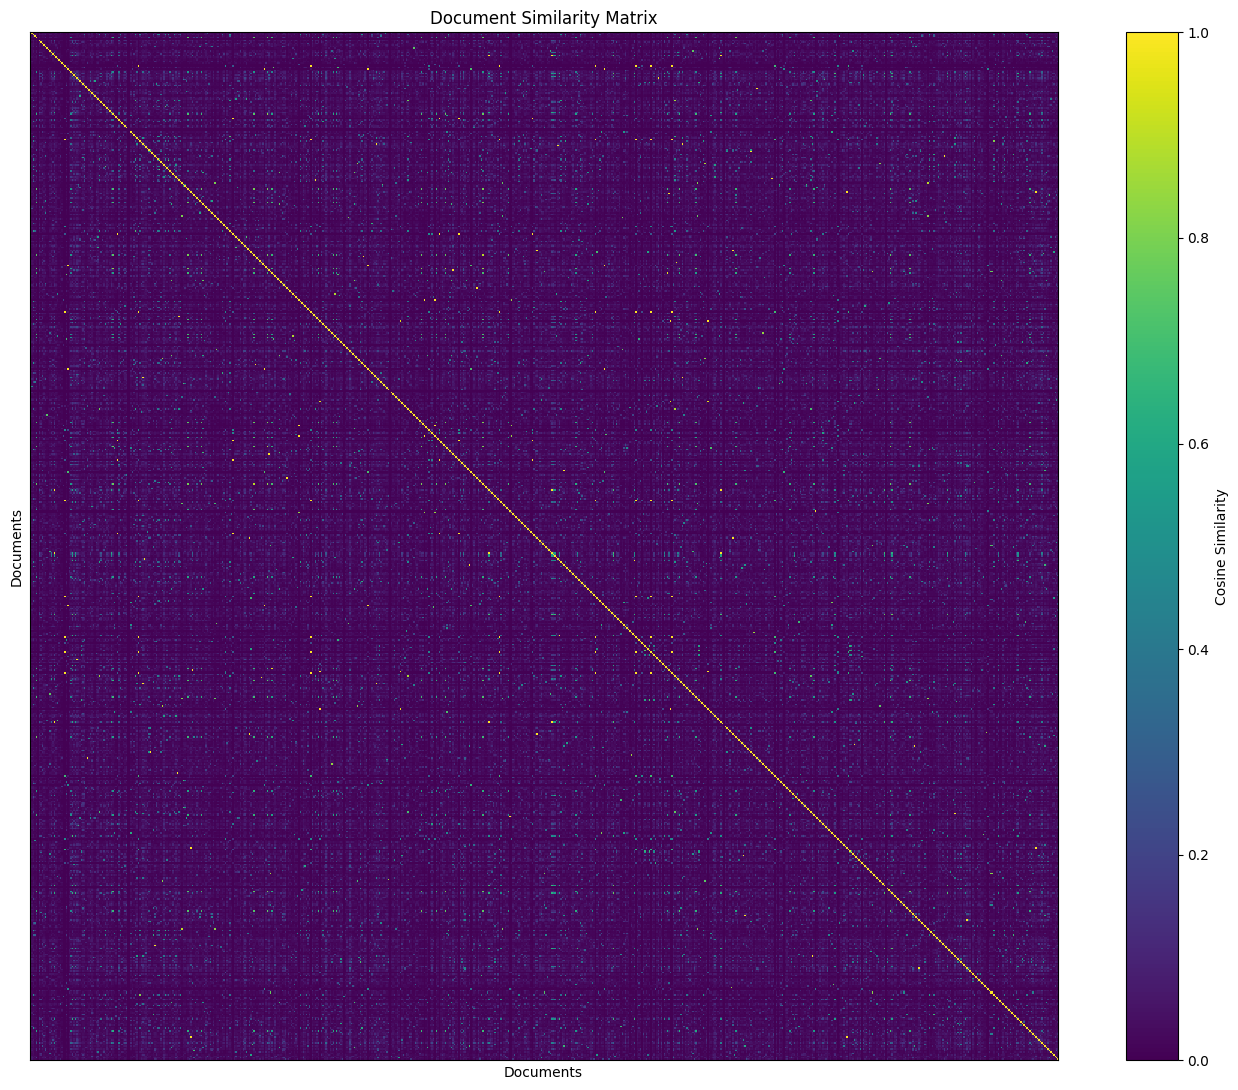

In [132]:
MBG_similarity_matrix = similarity_matrix(MBG_tf_idf)

print(MBG_similarity_matrix)

plot_similarity_matrix(MBG_similarity_matrix)

###### For Wikipedia

,https://en.wikipedia.org/wiki/LCCN_(identifier),https://en.wikipedia.org/wiki/Maternal_health,https://en.wikipedia.org/wiki/Orienteering,https://en.wikipedia.org/wiki/Pessimism,https://en.wikipedia.org/wiki/Holocene,https://en.wikipedia.org/wiki/Etiology,https://en.wikipedia.org/wiki/Baluster
https://en.wikipedia.org/wiki/LCCN_(identifier),1.000000,0.106418,0.120561,0.110252,0.108561,0.023928,0.059837
https://en.wikipedia.org/wiki/Maternal_health,0.106418,1.000000,0.260921,0.417324,0.325047,0.357823,0.161760
https://en.wikipedia.org/wiki/Orienteering,0.120561,0.260921,1.000000,0.154406,0.344590,0.067541,0.135094
https://en.wikipedia.org/wiki/Pessimism,0.110252,0.417324,0.154406,1.000000,0.264664,0.227530,0.209880
https://en.wikipedia.org/wiki/Holocene,0.108561,0.325047,0.344590,0.264664,1.000000,0.105431,0.187370
https://en.wikipedia.org/wiki/Etiology,0.023928,0.357823,0.067541,0.227530,0.105431,1.000000,0.084986
https://en.wikipedia.org/wiki/Baluster,0.059837,0.161760,0.135094,0.209880,0.187370,0.084986,1.000000


                                                 https://en.wikipedia.org/wiki/LCCN_(identifier)  \
https://en.wikipedia.org/wiki/LCCN_(identifier)                                         1.000000   
https://en.wikipedia.org/wiki/Maternal_health                                           0.106418   
https://en.wikipedia.org/wiki/Orienteering                                              0.120561   
https://en.wikipedia.org/wiki/Pessimism                                                 0.110252   
https://en.wikipedia.org/wiki/Holocene                                                  0.108561   
https://en.wikipedia.org/wiki/Etiology                                                  0.023928   
https://en.wikipedia.org/wiki/Baluster                                                  0.059837   

                                                 https://en.wikipedia.org/wiki/Maternal_health  \
https://en.wikipedia.org/wiki/LCCN_(identifier)                                       0.106418   
htt

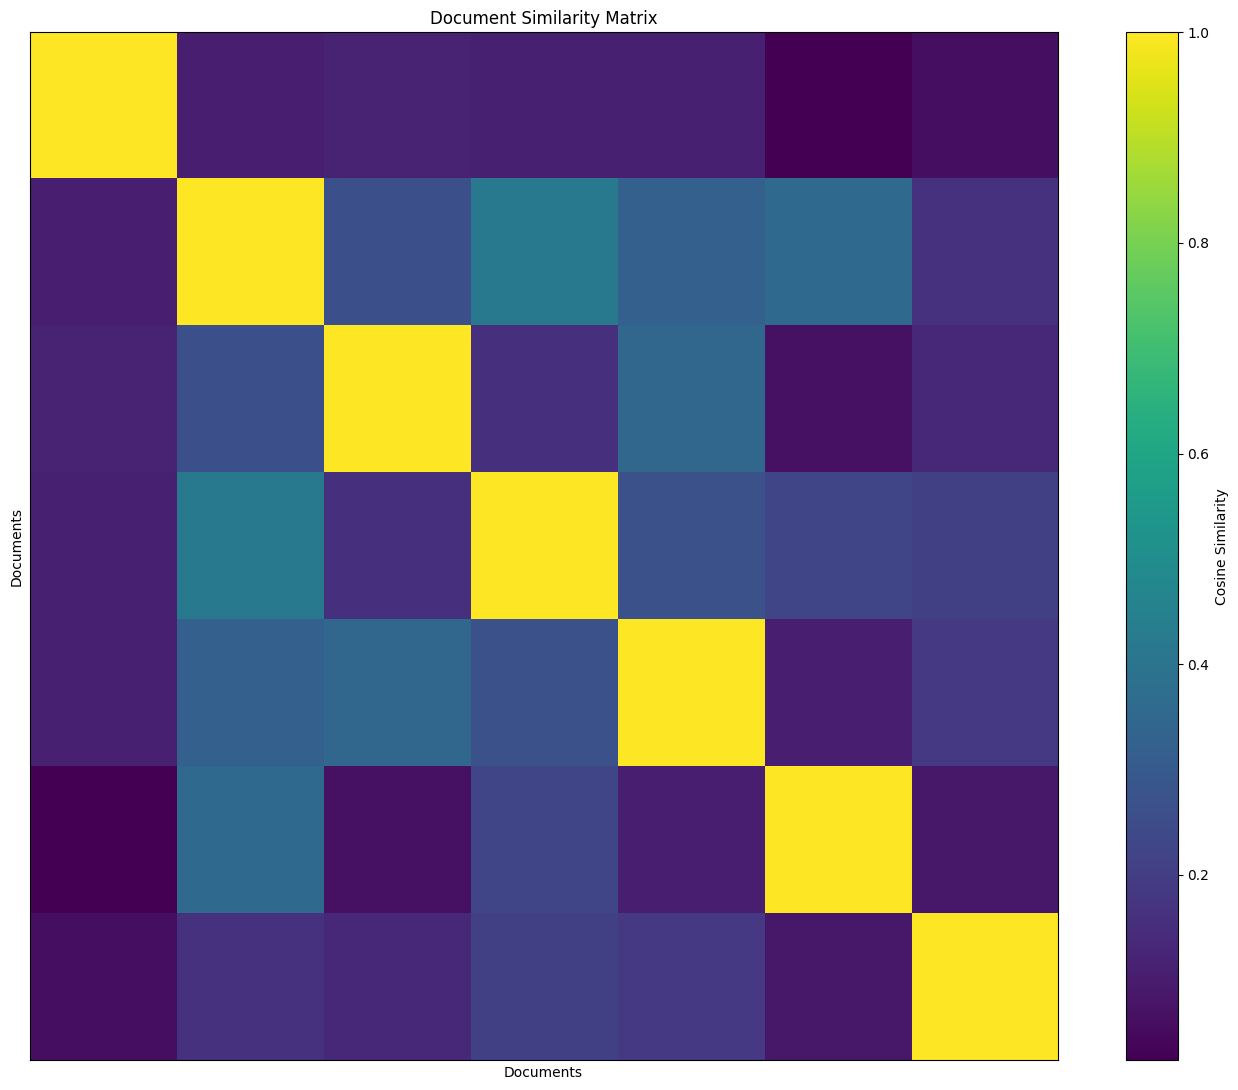

In [37]:
wiki_similarity_matrix = similarity_matrix(wiki_tf_idf)

print(wiki_similarity_matrix)

plot_similarity_matrix(wiki_similarity_matrix)

## Most frequent words

###### For MindBodyGreen

In [133]:
all_tokens = [tok for tokens in tokenized_MBG_csv["tokenized_text"] for tok in tokens]  # Create a list with all the tokens
MBG_word_freq = Counter(all_tokens)  # Count the number of times a token appears in the list
MBG_word_freq.most_common(20)  # Print only the 20 most frequent

[('health', 2474),
 ('protein', 2024),
 ('skin', 1921),
 ('muscle', 1867),
 ('food', 1633),
 ('sleep', 1232),
 ('support', 1220),
 ('need', 1181),
 ('supplement', 1155),
 ('product', 1149),
 ('may', 1117),
 ('people', 1072),
 ('brain', 1031),
 ('benefit', 1025),
 ('disease', 1013),
 ('level', 953),
 ('exercise', 939),
 ('feel', 936),
 ('high', 931),
 ('healthy', 902)]

###### For Wikipedia

In [43]:
all_tokens = [tok for tokens in tokenized_wiki_csv["tokenized_text"] for tok in tokens]  # Create a list with all the tokens
wiki_word_freq = Counter(all_tokens)  # Count the number of times a token appears in the list
wiki_word_freq.most_common(20)  # Print only the 20 most frequent

[('woman', 114),
 ('maternal', 107),
 ('health', 100),
 ('pregnancy', 83),
 ('orienteering', 80),
 ('holocene', 76),
 ('care', 62),
 ('birth', 61),
 ('mother', 58),
 ('world', 57),
 ('bp', 55),
 ('event', 52),
 ('country', 51),
 ('rate', 50),
 ('mortality', 40),
 ('death', 39),
 ('period', 38),
 ('pessimism', 38),
 ('year', 35),
 ('human', 33)]

## Words cloud

#### Definitions implementation

In [134]:
def plot_wordcloud(word_freq, title):
    
    wc = WordCloud(width=900, height=450, background_color="white").generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=15, pad=20) # Ajout d'un titre pour ne pas les confondre
    plt.show()

#### Execution

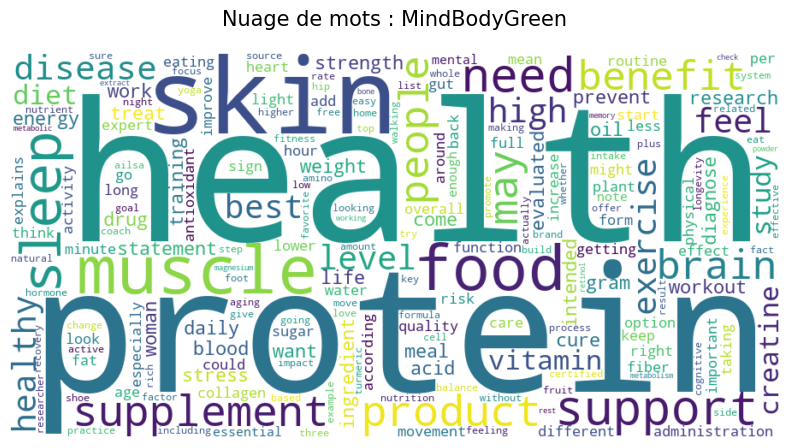

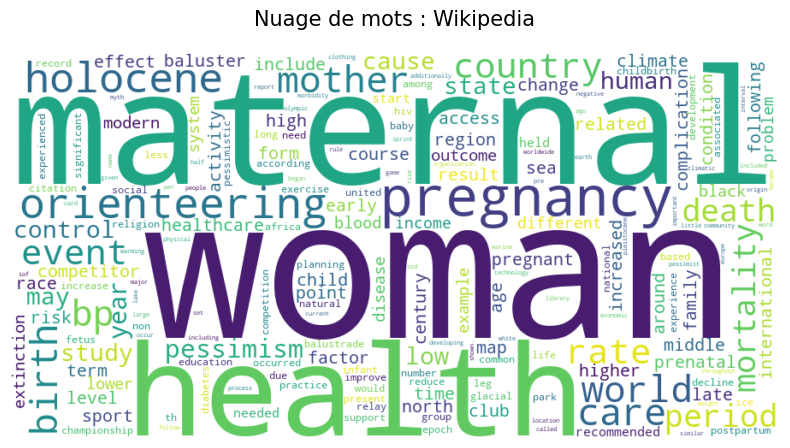

In [135]:
plot_wordcloud(MBG_word_freq, "Nuage de mots : MindBodyGreen")
plot_wordcloud(wiki_word_freq, "Nuage de mots : Wikipedia")

## Analyse thématique MBG

In [136]:
MBG_tf_idf_clean = MBG_tf_idf.replace([np.inf, -np.inf], np.nan).fillna(0)
# Cleaning TF-IDF: replace infinite values with NaN, then replace NaN with 0
# Essential because some operations (e.g., divisions) can produce inf/-inf, and many algos crash with NaN

In [137]:
def plot_elbow(tf_idf, max_k=10):
    
    inertias = [] # List to store inertia (SSE) for each k
    n_docs = tf_idf.shape[0] # Number of documents (= number of rows)
    max_k = min(max_k, n_docs - 1) # Safety check: k cannot exceed n_docs-1
    K_values = range(2, max_k) # Avoiding test if k=1

    for k in K_values: # Loop over k values to train KMeans and retrieve inertia
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(tf_idf)
        inertias.append(kmeans.inertia_) # Inertia = sum of intra-cluster distances

    plt.figure(figsize=(8,5))
    plt.plot(K_values, inertias, marker='o') 
    plt.xlabel("Nombre de clusters (k)")
    plt.ylabel("Inertia (distortion)")
    plt.title("Méthode du coude (Elbow Method)")
    plt.grid(True)
    plt.show()

    # Heuristic to approximate the "knee":
    # we look for the point with the largest successive "drop" in inertia
    deltas = np.diff(inertias)
    best_k_idx = np.argmin(deltas) + 1 # index of the "biggest drop" (most negative) +1 because diff shifts by 1
    best_k = K_values[best_k_idx]
    best_inertia = inertias[best_k_idx]

    return best_k, best_inertia, K_values, inertias


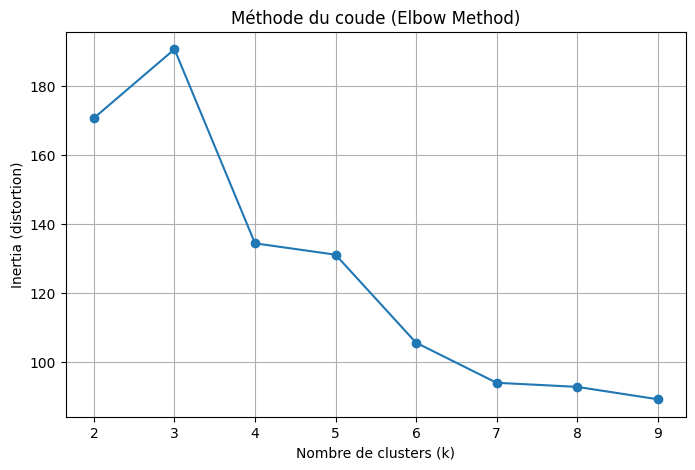

Best k : 4
Associated inertia : 134.4373989810788


In [138]:
best_k, best_inertia, K_values, inertias = plot_elbow(MBG_tf_idf_clean, max_k=10)
print("Best k :", best_k)
print("Associated inertia :", best_inertia)

In [139]:
def plot_silhouette(tf_idf, max_k=10):
    
    scores = []
    n_docs = tf_idf.shape[0]
    max_k = min(max_k, n_docs - 1)
    K_values = range(2, max_k)

    for k in K_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(tf_idf) # Fits and returns the cluster assigned to each doc
        score = silhouette_score(tf_idf, labels) # Measures separation vs compactness (higher = better)
        scores.append(score)

    plt.figure(figsize=(8,5))
    plt.plot(K_values, scores, marker='o')
    plt.xlabel("k")
    plt.ylabel("Silhouette score")
    plt.title("Méthode du Silhouette Score")
    plt.grid(True)
    plt.show()

    best_score = max(scores) # Select the best k: the one that maximizes the silhouette score
    best_k = K_values[scores.index(best_score)] 
    
    return best_k, best_score, list(K_values), scores

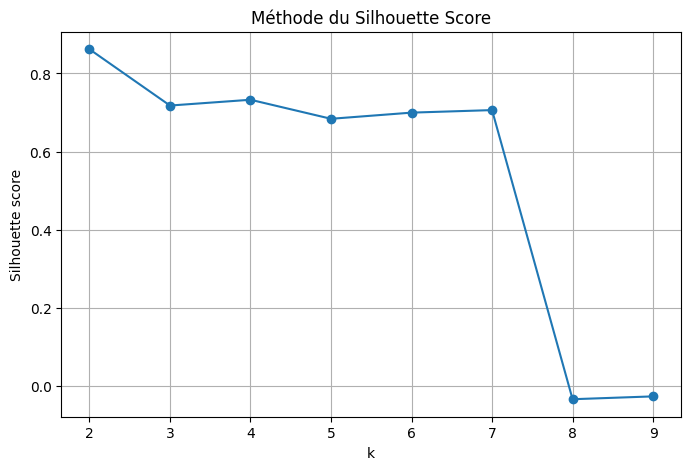

Best k : 2
Associated silhouette score : 0.8618337818516607


In [140]:
best_k, best_score, ks, scores = plot_silhouette(MBG_tf_idf_clean) 

print("Best k :", best_k) 
print("Associated silhouette score :", best_score)

Attention : on prend 5 pour k et pas 4 parce que les clusters sont mesurés sur base de tokens (= pas de stopwords ou custom_stopwords) sauf que Bert est sur normalized_text et même si on prend dans vectorizer les stopwords, Bert ne les exclut pas donc on prend k+1 car un cluster sera pour les noms.

In [141]:
MBG_k = 4
MBG_kmeans = KMeans(n_clusters=MBG_k, random_state=42)
MBG_tf_idf_clean['cluster'] = MBG_kmeans.fit_predict(MBG_tf_idf_clean)

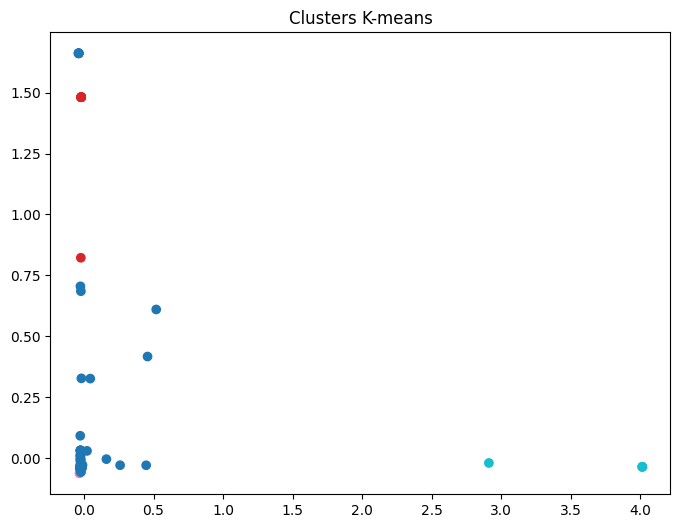

In [142]:
pca = PCA(n_components=2)
coords = pca.fit_transform(MBG_tf_idf_clean.drop(columns=['cluster']))

MBG_pca_df = pd.DataFrame(coords, columns=['x','y'], index=MBG_tf_idf_clean.index)

plt.figure(figsize=(8,6)) 
plt.scatter(MBG_pca_df['x'], MBG_pca_df['y'], c=MBG_tf_idf_clean['cluster'], cmap='tab10') 
plt.title("Clusters K-means") 
plt.show()

## Bertopic model

#### Definitions implementation

In [157]:
def bertopic_hdbscan(normalized_corpus, min_words=30, embedding_model_name="all-MiniLM-L6-v2", nr_words=20, min_df=2, max_df=0.8, stop_words=None):
    """
    Pipeline BERTopic optimisé avec HDBSCAN.
    - Clustering naturel
    - Thèmes cohérents
    - Représentation KeyBERTInspired
    - Vectorizer calibré pour corpus MBG
    """

    # Load corpus
    df = pd.read_csv(normalized_corpus)
    documents = df["normalized_text"].astype(str).tolist()

    # Remove short documents
    documents = [d for d in documents if len(d.split()) >= min_words]

    # Embedding model
    embedding_model = SentenceTransformer(embedding_model_name)

    # Vectorizer
    vectorizer_model = CountVectorizer(
        stop_words=stop_words,
        min_df=min_df,
        max_df=max_df,
        max_features=5000
    )

    # Representation model
    representation_model = KeyBERTInspired(top_n_words=nr_words)

    # HDBSCAN clustering
    hdbscan_model = HDBSCAN(
        min_cluster_size=15,
        metric='euclidean',
        cluster_selection_method='eom'
    )

    # BERTopic model
    topic_model = BERTopic(
        embedding_model=embedding_model,
        vectorizer_model=vectorizer_model,
        hdbscan_model=hdbscan_model,
        representation_model=representation_model,
        verbose=True
    )

    # Fit + transform
    topics, probs = topic_model.fit_transform(documents)

    return topic_model, topics, probs, documents

#### Execution

###### For MindBodyGreen

In [ ]:
MBG_bert, MBG_topics, MBG_probs, MBG_docs = bertopic_hdbscan("data/MBG_normalized_corpus.csv", min_words=50, nr_words=100, min_df=2, max_df=0.8, stop_words=list(ALL_STOPWORDS))

ValueError: Invalid file path or buffer object type: <class 'dict'>

###### For Wikipedia

In [60]:
wiki_bert, wiki_topics, wiki_probs, wiki_docs = bertopic_hdbscan( "data/wiki_normalized_corpus.csv", min_words=50, nr_words=100, min_df=2, max_df=0.8, stop_words=list(ALL_STOPWORDS))

2026-01-05 17:54:04,499 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 1/1 [00:00<00:00,  1.99it/s]
2026-01-05 17:54:05,019 - BERTopic - Embedding - Completed ✓
2026-01-05 17:54:05,021 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-05 17:54:05,079 - BERTopic - Dimensionality - Completed ✓
2026-01-05 17:54:05,082 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-05 17:54:05,088 - BERTopic - Cluster - Completed ✓
2026-01-05 17:54:05,093 - BERTopic - Representation - Fine-tuning topics using representation models.


ValueError: max_df corresponds to < documents than min_df

## Topic and main topic identification

#### Definitions implementation

In [ ]:
def summarize_topics(topic_model, top_words=3, max_words=100, min_score=0.1):
    topic_info = topic_model.get_topic_info()  # Retrieve general information about topics (Topic ID, document count, name)
    topic_info = topic_info[topic_info.Topic != -1]  # Remove the outlier topic (-1), which BERTopic uses for noise

    # Identify the main topic: the one with the highest document count
    main_topic_id = (
        topic_info.sort_values(by="Count", ascending=False)  # Sort topics by number of documents
        .topic   # Select the Topic column
        .iloc[0]  # Take the first (most frequent) topic
    )

    themes = {}  # Initialize dictionary that will store themes and their keywords
    
    for topic_id in topic_info.topic:  # Loop through each topic ID
        words_scores = topic_model.get_topic(topic_id)  # Retrieve list of pairs (word and score) for the topic
        words = [ word for word, score in words_scores if score >= min_score][:max_words]  # Filter words by minimum score and limit total number of words

        theme_name = ", ".join(words[:top_words])  # Create a short theme name using the top (top_words) words
        count_docs = topic_info.loc[topic_info.Topic == topic_id, "Count"].values[0]  # Retrieve the number of documents associated with this topic
        is_main_topic = (topic_id == main_topic_id)  # Check whether this topic is the main topic
        themes[theme_name] = {"keywords": words}  # Store keywords for this theme in the dictionary
        
        print(f"Theme: {theme_name}")                            
        print("Numbers of documents", count_docs)
        print(words)
        
        if is_main_topic:
            main_topic_words = words  # If this is the main topic, store its words separately
            print("-> This is the main topic")

        print("-" * 60)  # Help us visualize the result
        
# ATTENTION : voir si cette ligne est nécessaire ??
    topic_df = topic_info.copy()  # Create a copy of the topic information DataFrame to return
    
    return themes, main_topic_words, topic_df

In [62]:
def filter_topic_words(main_topic_words):
    filtered_words = []
    
    for word in main_topic_words :
        
        if len(word) <= 2 :
            continue
        
        if word in full_stop_words :
            continue
        
        filtered_words.append(word)
    return filtered_words

In [ ]:
def datamuse_synonyms(word):
    synonyms = set()

    url_syn = f"https://api.datamuse.com/words?rel_syn={word}"  # Build the Datamuse API URL to request synonyms of the given word
    
    try:
        response = requests.get(url_syn, timeout=5).json()  # Send the request with a timeout and parse the JSON response
        
        for item in response:  # Iterate through each returned item (each potential synonym)
            
            if item.get("score", 0) > 500:  # Keep only synonyms with a high relevance score (> 500)
                synonyms.add(item["word"])  # Add the synonym to the set
    
    except Exception:
        pass  # Ignore any network or parsing errors

    return list(synonyms)

In [ ]:
# Check whether the input string corresponds to a real, commonly used English word. 
# # The function uses the Zipf frequency score: higher values indicate more frequent words. 
# # A word is considered "real" if its Zipf score is above the given threshold.

def is_real_word(word, threshold=1.5):  # Verify if a word is a real word
    return zipf_frequency(word, "en") >= threshold

In [63]:
def expand_with_synonyms(word_list):

    expanded = set()

    for word in word_list:
        expanded.add(word.lower())  # Always keep the original word (no filtering applied here)
       
        for variant in [word + "s", word + "ing", word + "ed"]:
            expanded.add(variant)  # Add simple morphological variants of the original word

        syns = datamuse_synonyms(word)  # Retrieve synonyms for the current word

        for s in syns:  # Process and filter only the synonyms
            s = s.lower().strip()

            if is_real_word(s):  # Check if the synonyme is a real word
              
                if len(s) <= 2:  # Skip very short tokens
                    continue
              
                if s in list(ALL_STOPWORDS):  # Skip stopwords
                    continue
              
                if len(s.split()) > 1:  # Skip multi‑word expressions (keep only single tokens)
                    continue

                expanded.add(s)  # Add the cleaned synonym

                for variant in [s + "s", s + "ing", s + "ed"]:  # Add morphological variants of the synonym, but only if they are real words
                    if is_real_word(variant):
                        expanded.add(variant)

    return sorted(expanded)

#### Execution

In [ ]:
MBG_themes, MBG_main_topic_words, MBG_topic_df = summarize_topics(MBG_bert, top_words=3)

In [ ]:
MBG_main_topic_words_filtered = filter_topic_words(MBG_main_topic_words)
print(len(MBG_main_topic_words_filtered), "keywords was found for the main topic :", MBG_main_topic_words[:3])
print("Here are the original keywords :", MBG_main_topic_words_filtered)

MBG_expanded_keywords = expand_with_synonyms(MBG_main_topic_words)
print("We enlarged the keywords and now have a list of", len(MBG_expanded_keywords), "keywords")

In [ ]:
# Créer un DataFrame
df = pd.DataFrame({"main_topic_words_filtered": [MBG_main_topic_words_filtered]}) # note les [ ] pour que ce soit UNE cellule

# Sauvegarder
df.to_csv("data/main_topic_words_filtered.csv", index=False)
print("The final list of words is saved in a file called : main_topic_words_filtered.csv")

## Temporality analysis

In [143]:
def count_themes(tokens, themes): 
    # Count the number of times a theme (or associated word) appears in each document (/ doc's tokens)
    
    counts = Counter()
    token_set = set(tokens)
    
    for theme, keywords in themes.items():
        counts[theme] = len(token_set & keywords)
    
    return counts

In [144]:
timeline_MBG = tokenized_MBG_csv.copy() # To be safer, we creat a copy of the dataframe
timeline_MBG ['date'] = pd.to_datetime(timeline_MBG['date'], errors='coerce') # Transforms the dates into correct dates frame and if the data is not convertible it becomes "Not a Time"
timeline_MBG = timeline_MBG.dropna(subset=['date']) # Delete all rows whith unvalid dates

KeyError: 'date'

In [ ]:
rows = []

for i, row in timeline_MBG.iterrows(): # For every line in the dataframe (timeline_MBG)
    tokens = row['tokenized_text'] # Collect the tokens in the correct column

    theme_counts = count_themes(tokens, themes) # Count the number of times the theme appears in the article's tokens

    for theme, count in theme_counts.items(): # For every theme and number of times it appears
        rows.append({ "date": row['date'],  "theme": theme, "count": count }) # Construction of a dictionnary for each date and for each theme and the number of times it appears

theme_timeline_MBG = pd.DataFrame(rows) # Transform the list of dictionaaries in a dataframe

In [ ]:
daily_evolution_timeline_MBG = (theme_timeline_MBG
    .groupby(['date', 'theme'])['count'] # Group the datas (theme_timeline_MBG) according to their date and theme
    .sum() # If multiples rows of theme_timeline_MBG has the same group (= same date and theme) it is sum to form only one row
    .reset_index() # Important to not have the columns changed into date, theme (which is done automatically by groupby)
    )

In [ ]:
# Pivot par jour
pivot = (daily_evolution_timeline_MBG .pivot(index='date', columns='theme', values='count') .fillna(0)) # We pivot the table

# Plot
pivot.plot(figsize=(12,6))

plt.title("Daily evolution of themes in lifestyle blogs")
plt.xlabel("Date")
plt.ylabel("Occurrences")
plt.legend(title="Themes")
plt.tight_layout()
plt.show()


In [ ]:
# Lissage par moyenne mobile sur 7 jours  -> A supprimer
daily_smoothed = pivot.rolling(window=7).mean()

daily_smoothed.plot(figsize=(14,6))
plt.title("Évolution quotidienne lissée (moyenne mobile 7 jours)")
plt.xlabel("Date")
plt.ylabel("Occurrences moyennes")
plt.tight_layout()
plt.show()


In [ ]:
# Load corpus
df = pd.read_csv("data/normalized_MBG_corpus.csv")
documents = df["normalized_text"].astype(str).tolist()
documents = [d for d in documents if len(d.split()) > 100] # Remove documents with less than a 100 words (they are too short and only makes noise)

# Embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2") # It transforms every document in a vector which have meaning 

# Vectorizer
vectorizer_model = CountVectorizer(
    stop_words="english",
    min_df=3,
    ngram_range=(1, 2)
)

# KMeans clustering (NO hdbscan)  -> clustering of documents per topic (we can ask for x cluster)
cluster_model = KMeans(
    n_clusters=6,
    random_state=42,
    n_init="auto"
)

# BERTopic without hdbscan
topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    hdbscan_model=cluster_model,
    verbose=True
)

topics, probs = topic_model.fit_transform(documents)

print(topic_model.get_topic_info())

In [ ]:
silhouette_scores = []
k_range = range(2, 16)

for k in k_range:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10)
    
    labels = kmeans.fit_predict(topic_model)
    
    score = silhouette_score(topic_model, labels)
    silhouette_scores.append(score)

    print(f"k = {k} | Silhouette Score = {score:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score pour différents nombres de clusters")
plt.grid(True)
plt.show()
